In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
import jax.numpy as jnp
from jax.experimental import host_callback
from tqdm.auto import tqdm
from functools import partial
import frozen_lake
import plotting
import qlearning
import actions
import mangoenv
import utils


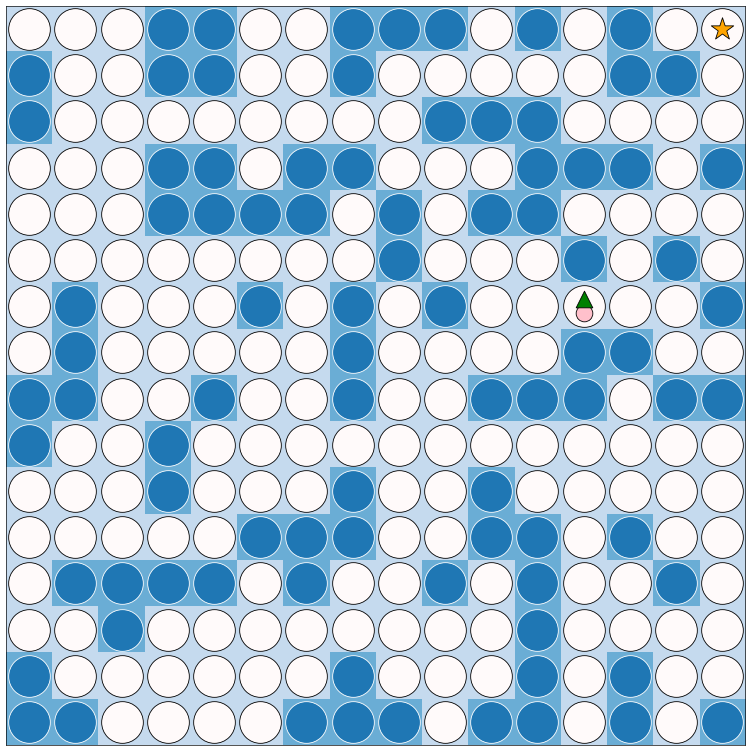

In [2]:
seed = 42
map_scale = 4

max_steps = 2**24
rollout_steps = 4**map_scale
n_rollouts = max_steps // rollout_steps
batch_size = 8 * rollout_steps

rng_env, rng_steps, rng_init =  jax.random.split(jax.random.PRNGKey(seed), 3)
rng_steps = jax.random.split(rng_steps, n_rollouts)

env = frozen_lake.FrozenLake.make_random(rng_env, map_scale, 0.5)
state, obs = env.reset(rng_env)
plotting.render(env, state)

In [3]:
from flax import linen as nn

n_comands = 5
MultiMLP = nn.vmap(
    utils.MLP,
    in_axes=None,  # type: ignore
    variable_axes={"params": 0},
    split_rngs={"params": True},
    axis_size=n_comands,
)


class InnerQnet(nn.Module):
    n_actions: int
    map_shape: tuple[int, int]

    @nn.compact
    def __call__(self, obs):
        x = jnp.zeros((*self.map_shape, 2))
        x = x.at[obs[0, 0], obs[0, 1], 0].set(1)
        x = x.at[obs[1, 0], obs[1, 1], 1].set(1)
        x = MultiMLP(self.hidden_size, self.n_actions)(x)
        return x


class OuterQnet(nn.Module):
    n_actions: int
    map_shape: tuple[int, int]

    @nn.compact
    def __call__(self, obs):
        x = jnp.zeros((*self.map_shape, 2))
        x = x.at[obs[0, 0], obs[0, 1], 0].set(1)
        x = x.at[obs[1, 0], obs[1, 1], 1].set(1)
        x = utils.MLP(self.n_actions)(x)
        return x


def sim_step(env, dql_state, rng_key, pbar):
    rng_expl, rng_train, rng_eval = host_callback.id_tap(
        lambda a, t: pbar.update(1), jax.random.split(rng_key, 3)
    )

    transitions = utils.random_rollout(env, rng_expl, rollout_steps)
    dql_state = dql_state.update_replay(transitions)

    transitions = dql_state.replay_buffer.sample(rng_train, batch_size)
    transitions = dql_state.process_transitions(transitions)
    dql_state = dql_state.update_params(transitions)
    return dql_state, None

  0%|          | 0/65536 [00:00<?, ?it/s]

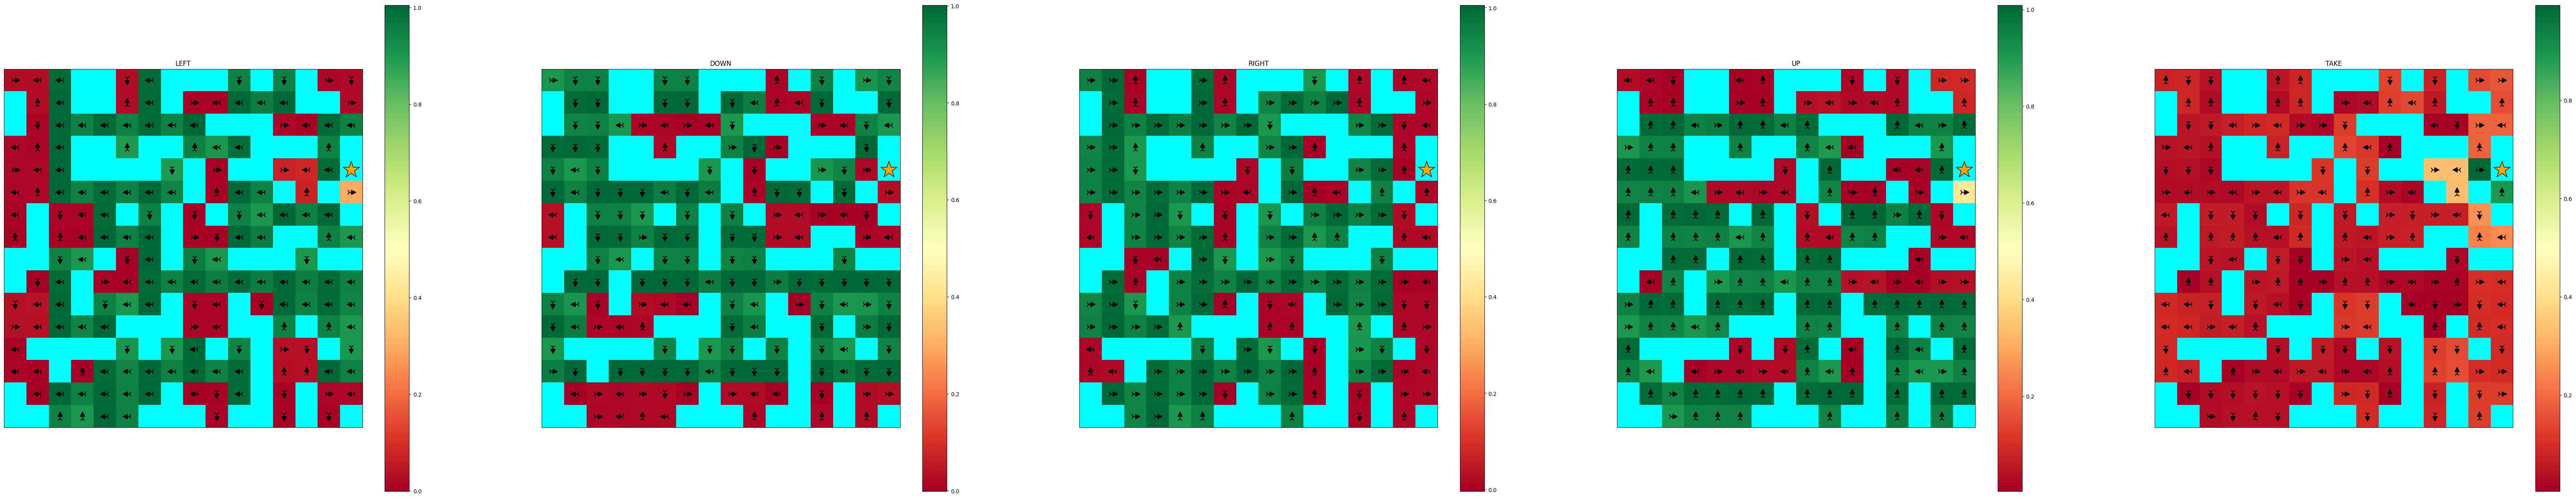

  0%|          | 0/65536 [00:00<?, ?it/s]

2024-02-21 06:36:50.400442: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.00GiB (rounded to 2147483648)requested by op 
2024-02-21 06:36:50.400586: W external/tsl/tsl/framework/bfc_allocator.cc:497] *********************************************************************************___________________
2024-02-21 06:36:50.401169: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2732] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2147483648 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    4.05GiB
              constant allocation:       202B
        maybe_live_out allocation:    4.04GiB
     preallocated temp allocation:   84.10MiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    8.18GiB
Peak buffers:
	Buffer 1:
		Size: 2.00GiB
		Entry Parameter Subshape: f32[1048576,16,16,2]

	Buffe

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2147483648 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    4.05GiB
              constant allocation:       202B
        maybe_live_out allocation:    4.04GiB
     preallocated temp allocation:   84.10MiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    8.18GiB
Peak buffers:
	Buffer 1:
		Size: 2.00GiB
		Entry Parameter Subshape: f32[1048576,16,16,2]
		==========================

	Buffer 2:
		Size: 2.00GiB
		Entry Parameter Subshape: f32[1048576,16,16,2]
		==========================

	Buffer 3:
		Size: 2.00GiB
		Operator: op_name="jit(scan)/jit(main)/while/body/jit(update_replay)/jit(extend)/scatter[update_jaxpr=None update_consts=() dimension_numbers=ScatterDimensionNumbers(update_window_dims=(1, 2, 3), inserted_window_dims=(0,), scatter_dims_to_operand_dims=(0,)) indices_are_sorted=False unique_indices=False mode=GatherScatterMode.FILL_OR_DROP]" source_file="/home/davide_sartor/MANGO-lite/btf/utils.py" source_line=80 deduplicated_name="fusion.154"
		XLA Label: fusion
		Shape: f32[1048576,16,16,2]
		==========================

	Buffer 4:
		Size: 2.00GiB
		Operator: op_name="jit(scan)/jit(main)/while/body/jit(update_replay)/jit(extend)/scatter[update_jaxpr=None update_consts=() dimension_numbers=ScatterDimensionNumbers(update_window_dims=(1, 2, 3), inserted_window_dims=(0,), scatter_dims_to_operand_dims=(0,)) indices_are_sorted=False unique_indices=False mode=GatherScatterMode.FILL_OR_DROP]" source_file="/home/davide_sartor/MANGO-lite/btf/utils.py" source_line=80 deduplicated_name="fusion.154"
		XLA Label: fusion
		Shape: f32[1048576,16,16,2]
		==========================

	Buffer 5:
		Size: 20.00MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/jit(update_params)/jvp(vmap(jit(temporal_difference)))/vmap(MLP)/mul" source_file="/home/davide_sartor/MANGO-lite/btf/utils.py" source_line=18 deduplicated_name="fusion.144"
		XLA Label: fusion
		Shape: f32[2048,5,512]
		==========================

	Buffer 6:
		Size: 20.00MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/jit(update_params)/jvp(vmap(jit(temporal_difference)))/vmap(MLP)/Dense_0/dot_general[dimension_numbers=(((1,), (1,)), ((), ())) precision=None preferred_element_type=None]" source_file="/home/davide_sartor/MANGO-lite/btf/utils.py" source_line=17
		XLA Label: custom-call
		Shape: f32[2048,2560]
		==========================

	Buffer 7:
		Size: 20.00MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/jit(update_params)/jvp(vmap(jit(temporal_difference)))/vmap(MLP)/mul" source_file="/home/davide_sartor/MANGO-lite/btf/utils.py" source_line=18 deduplicated_name="fusion.144"
		XLA Label: fusion
		Shape: f32[2048,5,512]
		==========================

	Buffer 8:
		Size: 20.00MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/jit(update_params)/jvp(vmap(jit(temporal_difference)))/vmap(MLP)/Dense_0/dot_general[dimension_numbers=(((1,), (1,)), ((), ())) precision=None preferred_element_type=None]" source_file="/home/davide_sartor/MANGO-lite/btf/utils.py" source_line=17
		XLA Label: custom-call
		Shape: f32[2048,2560]
		==========================

	Buffer 9:
		Size: 8.00MiB
		Entry Parameter Subshape: s32[1048576,2]
		==========================

	Buffer 10:
		Size: 8.00MiB
		Entry Parameter Subshape: s32[1048576,2]
		==========================

	Buffer 11:
		Size: 8.00MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/jit(update_replay)/jit(extend)/scatter[update_jaxpr=None update_consts=() dimension_numbers=ScatterDimensionNumbers(update_window_dims=(1,), inserted_window_dims=(0,), scatter_dims_to_operand_dims=(0,)) indices_are_sorted=False unique_indices=False mode=GatherScatterMode.FILL_OR_DROP]" source_file="/home/davide_sartor/MANGO-lite/btf/utils.py" source_line=80 deduplicated_name="fusion.120"
		XLA Label: fusion
		Shape: s32[1048576,2]
		==========================

	Buffer 12:
		Size: 8.00MiB
		Operator: op_name="jit(scan)/jit(main)/while/body/jit(update_replay)/jit(extend)/scatter[update_jaxpr=None update_consts=() dimension_numbers=ScatterDimensionNumbers(update_window_dims=(1,), inserted_window_dims=(0,), scatter_dims_to_operand_dims=(0,)) indices_are_sorted=False unique_indices=False mode=GatherScatterMode.FILL_OR_DROP]" source_file="/home/davide_sartor/MANGO-lite/btf/utils.py" source_line=80 deduplicated_name="fusion.120"
		XLA Label: fusion
		Shape: s32[1048576,2]
		==========================

	Buffer 13:
		Size: 5.00MiB
		Entry Parameter Subshape: f32[5,512,512]
		==========================

	Buffer 14:
		Size: 5.00MiB
		Entry Parameter Subshape: f32[5,512,512]
		==========================

	Buffer 15:
		Size: 5.00MiB
		Entry Parameter Subshape: f32[5,512,512]
		==========================



In [4]:
abs_env = env
for cell_scale in range(1, map_scale):
    # inner stages
    reward_fn = partial(actions.reward_fn, cell_scale)
    beta_fn = partial(actions.beta_fn, cell_scale)

    #qnet = MultiMLP(abs_env.action_space.n)
    qnet = Qnet(abs_env.action_space.n, env.frozen.shape)
    dql_state = qlearning.MultiDQLTrainState.create(
        rng_init, qnet, abs_env, reward_fn=reward_fn, beta_fn=beta_fn
    )

    pbar = tqdm(range(n_rollouts))
    dql_state, rewards = jax.lax.scan(partial(sim_step, abs_env, pbar=pbar), dql_state, rng_steps)

    get_qval_fn = jax.jit(lambda obs: dql_state.qval_apply_fn(dql_state.params_qnet, obs))
    plotting.plot_qvals(env, get_qval_fn, tasks=["LEFT", "DOWN", "RIGHT", "UP", "TAKE"])

    abs_env = mangoenv.MangoEnv(abs_env, dql_state, max_steps=4)
    rollout_steps = rollout_steps // 2

# outer stage
qnet = utils.MLP(abs_env.action_space.n)
dql_state = qlearning.DQLTrainState.create(rng_init, qnet, abs_env)

pbar = tqdm(range(n_rollouts))
dql_state, rewards = jax.lax.scan(partial(sim_step, abs_env, pbar=pbar), dql_state, rng_steps)

get_qval_fn = jax.jit(lambda obs: dql_state.qval_apply_fn(dql_state.params_qnet, obs))
plotting.plot_qvals(env, get_qval_fn)